In [93]:
util_midi.midi_roll_play(Ys[:500])

array([ 0.        ,  0.23725154,  0.47004789, ...,  1.30295946,
        1.21591135,  1.10430221])

In [3]:
from util_nn import *


import matplotlib 
import matplotlib.pyplot as plt
#%matplotlib inline
import IPython.display as ipd
import copy
import util_midi
import mir_eval
from util_midi import *
%matplotlib inline

def rmsq(X):
    return np.sqrt((X**2).mean())
def norm_by_freq(mroll):
    #### This may be improved
    wt = (np.linspace(0,1,mroll.shape[1])).T
#         sqwt = wt**2
#         sq_mroll = mroll **2
#         SUM = (sq_mroll*sqwt).sum(axis = 1,keepdims = 1)
    mroll = mroll*wt
    SUM = mroll.sum(axis = 1,keepdims = 1)
#         SUM = (mroll*wt).sum(axis = 1,keepdims = 1)
    SUM[SUM==0]=1
    mroll = mroll/SUM.astype('float32')
    return mroll

def mroll2chroma(mroll,norm = 1):
#     if chroma:
    if mroll.shape[-1]==12:
        return mroll
    mroll = mroll[:,:120]
    SP = list(mroll.shape)
#         SP[1] = 12; SP.append(-1)
#         mroll = np.reshape(mroll,SP).sum(axis = 2)
    SP[1] = -1; SP.append(12)
#     cmroll = np.clip(cmroll,0,1)
    #     cmroll = 
    if norm:
        mroll = norm_by_freq(mroll)
        

#         SUM = cmroll.sum(axis = 1,keepdims =1 )
#         SUM[SUM==0]=1
#         cmroll = cmroll / SUM.astype(float)
#     cmroll = (np.reshape(mroll,SP).sum(axis = 1) > 0).astype('float')
    cmroll = (np.reshape(mroll,SP).sum(axis = 1)).astype('float')
#         cmroll = np.clip(cmroll,0,1)
    return cmroll 
#     print mroll.shape

    
def midi_roll_play(mroll,chroma = False):
    if mroll.shape[-1]==12:
        freqs = mir_eval.transcription.util.midi_to_hz(np.arange(60,72))
    else:
        freqs = mir_eval.transcription.util.midi_to_hz(np.arange(0,128))
#     mroll = np.log(mroll+1E-5)
    SHAPE = mroll.shape
    mroll = mroll.T
#     mroll = mroll * freqs.T[:,None]
#     mroll = norm_by_freq(mroll)
    Xs_exp = mir_eval.sonify.time_frequency( mroll ,freqs,times = 1./20*np.arange(SHAPE[0]),fs = 16000)
#     Xs_exp = np.hstack([Xs_exp,[0]*(len(cpXs)-len(Xs_exp))])
    return Xs_exp/np.sqrt((Xs_exp**2).mean())

def log_plot(Z1,eps = 1E-5):
    Z1 = abs(Z1)
    Z1 += eps
    plt.pcolormesh(Z1,
                   alpha = 0.5,
              norm=matplotlib.colors.LogNorm(vmin=Z1.min(), vmax=Z1.max())
              )
def compare(log = 1, mode = 'test',best_agent = None,chroma = False,overlap = 1, loss_func = None,callbacks = None):
    FSIZE = [12,4]
    if best_agent is None:
        best_agent = copy.copy(agent)
        best_agent.load()
    plt.figure(figsize = FSIZE)

    if mode == 'test':
        pXs = data[0]["X"][:100]
        pYs_exp = data[0]["Y"][:100]
    else:
        pXs = Xs[:100]
        pYs_exp = Ys[:100]
#     assert not (pXs[0] - Xs[0]).any()
#     pXs = Xs[:500]
#     pYs_exp = Ys[:500]
    pYs_act = best_agent.model.predict_on_batch(pXs) 
    pYs_act += 1E-5
#     compare(log = 1)
    if chroma:
        if pYs_exp.shape[-1]==128:
            pYs_exp = mroll2chroma(pYs_exp,norm = 1)
        if pYs_act.shape[-1]==128:
            pYs_act = mroll2chroma(pYs_act,norm = 1)
    plt.pcolormesh(pYs_exp.T,alpha = 0.75)
    if overlap:
        pass
    else:
        plt.figure(figsize = FSIZE)
        
    Z1 = pYs_act.T
    def log_plot(Z1,eps = 1E-5):
        Z1 = abs(Z1)
        Z1 += eps
        plt.pcolormesh(Z1,
                       alpha = 0.5,
                  norm=matplotlib.colors.LogNorm(vmin=Z1.min(), vmax=Z1.max())
                  )
    if log:
        log_plot(Z1)
    else:
        plt.pcolormesh(Z1)
#     if overlap:
#         pass
#     else:
    if 1:
        plt.figure(figsize = FSIZE)
    if loss_func is not None:
        loss = loss_func(pYs_exp, pYs_act)
    else:
        loss = (pYs_act - pYs_exp)
    
    Z1 = loss.T
    if log:
        log_plot(Z1)
    else:
        plt.pcolormesh(Z1)        
#     plt.pcolormesh( loss.T )
        
    if chroma:
        YLIM = [0,12]
    else:
        YLIM = [40,90]
    plt.gca().set_ylim(YLIM)
#     plt.gca().set_xlim(0,200)
#     plt.gca().set_ylim(YLIM)
#     plt.figure()
    
    ipd.display(ipd.Audio(midi_roll_play(pYs_act),rate = 16000))
    ipd.display(ipd.Audio(midi_roll_play(pYs_exp),rate = 16000))
    cpXs = np.concatenate(pXs,axis = 0)
    ipd.display(ipd.Audio(cpXs,rate = 16000))

    
# ali = 'test'
# alias = 't4'
def pretrain(agent = None, batchsize = 30000,nepc = 10,bsize = 512,callbacks = None):
    IniEPOCH=0
    if agent is None:
        agent = PGAgent(16000/20, 128,model = make_model())

    # data = load_data()
    # Xs,Ys = make_buffer(data[1:])
    if batchsize== -1:
        batchsize = len(Xs)
    idx = np.random.choice(len(Xs),batchsize,replace=0)
    subXs = Xs[idx]
    subYs = Ys[idx]

#     opt_par.update({'loss':LOSS})
    opt = keras.optimizers.sgd(**opt_par)
    try:
    #     agent.load()
        pass
    except Exception as e:
        print e
    # opt_par = {}
    # opt = keras.optimizers.Adam(**opt_par)
    # agent.name = "adam_%s"%opt_par_flat

    opt_par_flat = '-'.join(['_'.join(str(y) for y in x) for x in opt_par.items()]).replace('.','Dot')
    agent.name = "sgd_%s_%s"% (alias,flatten_param(opt_par))



    agent.model.compile(loss=LOSS, optimizer=opt
                         ,metrics=['accuracy'])

#     nepc = 10
    r = agent.model.fit(subXs, subYs, epochs= IniEPOCH + nepc, initial_epoch=IniEPOCH, batch_size=bsize, validation_split=0.2,shuffle = 1, verbose = 1,
                         callbacks=callbacks)
    IniEPOCH += nepc
    plot_model_loss(r)
    return agent,r
# agent = pretrain()
# compare(log = 1, mode = 'test',chroma = 1)
# compare(log = 1, mode = 'test',chroma = 0)

# pXs = data[0]["X"][:100]
# pYs_exp = data[0]["Y"][:100]
# ipd.display(ipd.Audio(midi_roll_play(pYs_exp,chroma = 1),rate = 16000))

import sys
# class ClearlineCallback(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         sys.stdout.write("\033[F")
#         sys.stdout.write("\033[F")
#         print "\r\r"
class NewlineCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print
    def on_epoch_end(self, epoch, logs={}):
        print
        pass
#         print "\n"
import keras


def default_callbacks(self):
    ck_all = self.callback_checkpoint(0)
    ck_best = self.callback_checkpoint(1)
    callbacks = [
#         ClearlineCallback(),
#         keras.callbacks.ProgbarLogger(),
                 NewlineCallback(),
                 ck_all,
                 ck_best,
#                  NewlineCallback()
                ]
    return callbacks
def loss_func(y_true,y_pred):
    K = np
    K.epsilon = lambda:1E-16
    y_true = K.clip(y_true, K.epsilon(), None)
    y_pred = K.clip(y_pred, K.epsilon(), None)
#    return K.sum( K.abs( (y_true- y_pred) * (K.log(y_true / y_pred))), axis=-1)
#     return K.prod( (y_true- y_pred) * (K.log(y_true / y_pred)), axis=-1)
    prod = (y_true- y_pred) * (K.log(y_true / y_pred))
#     return K.sum( K.exp(K.sum( K.log( prod +  K.epsilon() ) ,axis = 1) )
#                 ,axis = -1)
#     return K.sum(prod,)

    return prod
# def abs_KL_div(y_true, y_pred):
#     y_true = K.clip(y_true, K.epsilon(), 1)
#     y_pred = K.clip(y_pred, K.epsilon(), 1)
#     return K.sum(y_true * K.abs(K.log(y_true / y_pred)), axis=-1)

In [109]:
from keras.engine.topology import Layer
import numpy as np

class MyLayer(Layer):

    def __init__(self, output_dim, min_value = None, max_value = None, **kwargs):
        self.output_dim = output_dim
        self.min_value = min_value
        self.max_value = max_value
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        return K.clip(x,min_value = self.min_value, max_value =self.max_value )

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)


In [ ]:
opt_par = {'lr': 0.01, 'momentum': 0.75,'decay':0.000}
# import keras
# LOSS = 'kullback_leibler_divergence'
# LOSS = 'mean_absolute_percentage_error'
# LOSS = 'hinge'
# LOSS = 'categorical_crossentropy'
# LOSS = 'binary_crossentropy'
alias = 't26'
ACT_FUNC = "relu"
# # ACT_FUNC = "selu"
# tf.device('/gpu:0')
# LOSS = 'sparse_categorical_crossentropy'
# LOSS = 'binary_crossentropy'
from keras.models import Model

import keras
import keras.backend

# Ns = [2,3,4,5,6][::-1]
Nl = 17
# Ns = [30]*Nl
# Ns = 8 * np.clip(np.arange(1, Nl+1),None,15)
Ns = 2 * np.clip(np.arange(1, Nl+1),None,15)
# Ss = [2,4,8,16,16,16,16,16,100,100,100]
Ss = (1.25 * np.clip(np.arange(1, Nl+1),None,5)).astype('int')
# Ss = [7] * Nl
# Ss = [2,4,8,16,32,64,128,256]
Ws = 2 * np.clip(np.arange(1, Nl+1),None,5)
# Ws = [7] * Nl
# Ws = [2] * Nl
# Ss = [2,2,2,3,4][::-1]
# Ns = [20,20,20]
# Ss = [16,16,16]
# LOSS = 'binary_crossentropy'
LOSS = abs_KL_div
# LOSS = 'kullback_leibler_divergence'

def make_model(self = None):
    import keras.backend as K
    model = Sequential()
#         model = Sequential_wrapper()
#         model.add(Reshape((80, 80, 1), input_shape=(self.state_size,)))
    
#     model.add(Reshape((self.state_size,1), input_shape=(self.state_size,)))
    input_size = 800; output_size = 128
    model.add(Reshape((input_size,1,1), input_shape=(input_size,)))

#     S = 85;niter = 1
    S = 9;niter = 2
#     S = 4;niter = 3    
    niter = 4
    n = S
    nextlayer = lambda x:(    x//n - 1)
    
    N0 = 64
    S2 = 30
    N2 = 10
    Lx = 800
    
#         if i == 0:

#     #         N = 1 if i==0 else N0
#             N = N0
#             if i==0:
#                 N2_curr = 1
#             else:
#                 N2_curr = N2
    N2_curr = 1
    N = 10
    # Headline input: meant to receive sequences of 100 integers, between 1 and 10000.
    # Note that we can name any layer by passing it a "name" argument.
    main_input = Input(shape=(800,), 
#                        dtype='int32', name='main_input'
                      )
    curr = Reshape((input_size,1,1), input_shape=(input_size,))(main_input)

    imax = len(Ns)
    for i in range(imax):
#     for i in range(int(np.log(800)/np.log(S))-1):
        N = Ns[i];S = Ss[i];W = Ws[i]
#         print curr.get_shape()
#         print type(curr._keras_shape[2])
#         print keras.backend.shape(curr)
        curr = Conv2D( N, ( W, 1),
#         curr = Conv2D( N, ( S*8, int(curr._keras_shape[2])),
#         curr = Conv2D( N, ( S*8, curr._keras_shape[2]//2),
                  dilation_rate = (S,1),
#                    strides=(S, 1),
                                     border_mode='valid',
#                              border_mode='dilated',
                                    activation=ACT_FUNC, init='he_uniform')(curr)
#         print curr._keras_shape
#         curr = Reshape((int(curr._keras_shape[1]),1,-1))(curr)
#         curr = Dense(int(curr.get_shape()[-1]))(curr)
        if i+1==imax:
#             curr = Dense(12)(curr)
            pass
#         curr = Permute((1,3,2))(curr)
    
#         conv=conv_layer(curr,(800//S + 800//(S+1))//2)
#         conv=conv_layer(curr,S)
#         clayer.append(
    curr = Flatten()(curr)
#     print curr.shape[1]
#     print curr._keras._shape[0]
#     shortcut = keras.layers.Conv2D(1, kernel_size=(1, 1), strides=_strides, padding='same')(curr)

    concat = curr
#     main_output = Dense(128,activation='softmax')(Flatten()(concat))
#     main_output = Dense(12,activation='softmax')(Flatten()(concat))
#     main_output = Dense(128,activation='sigmoid')(Flatten()(concat))

#     curr = Dense(128,activation='relu')(curr)
#     total= Dense(1,activation='relu')(concat)
#     curr = keras.layers.add([curr , total])
#     main_output = Activation(activation = 'softmax')(curr)

#     out1 = Dense(1,activation='sigmoid')(concat)
    out1 = Dense(12,activation='softmax')(concat)
#     out1 = Dense(128,activation='softmax')(concat)
#     out2 = Dense(128,activation='softmax')(curr)
    out2 = None
#     out3 = Dense(128,activation='softmax')(curr)
    out3 = None
    total= keras.layers.Lambda(lambda x: K.clip(x,0.01,None))(
        Dense(1,activation='relu')(concat))
#     total =         Dense(1,activation='relu')(concat)
#     total= keras.layers.Lambda(lambda x: keras.backend.clip(x,0.01,None))(
#         Dense(1,activation='relu')(main_input))
#     total= keras.layers.Lambda(lambda x: keras.backend.clip(x,0.01,1.01))(
#         Dense(1,activation='relu')(main_input))
# BatchNormalization    
    Llst = [(out) for out in [out1,out2,out3] if out is not None]
#     Llst = [BatchNormalization(axis=1)(out) for out in [out1,out2,out3] if out is not None]
    if len(Llst) > 1: 
        main_output = keras.layers.add(Llst)
    else:
        main_output = Llst[0]
#     main_output = keras.layers.multiply([main_output,total])
#     main_output = total
    
#     main_output = keras.layers.multiply([main_output,total])

    #     shortcut = keras.layers.Lambda(lambda x: x + 0, )(curr)
#     noise_input = keras.models.Input((1,))
    
#     curr = keras.layers.GaussianNoise(.1)(curr)
#     curr = concatenate([curr,
# #                         noise_input,
#                        ]
#                         )
#                       keras.layers.GaussianNoise(.1)()])
#     curr = keras.layers.add(
#         [
#             keras.layers.GaussianNoise(.1),
# #             Dense(128,activation = 'relu')(shortcut),
#             Dense(128,activation = 'relu')(curr),
# #             shortcut
#         ]
#     )
#     main_output = Dense(128,activation='softmax')(curr)
#     main_output = Dense(12,activation='softmax')(Flatten()(concat))
    opt = Adam()
    model.compile(loss=LOSS, optimizer=opt
                 ,metrics=['accuracy'])
    model = Model(inputs=[main_input,
#                           noise_input
                         ], 
                  outputs=[main_output])
    return model
m = make_model()
m.summary()

In [131]:
old_model = agent.model

In [5]:
agent.load()

In [115]:
# agent.alias  ='t26'
# agent.name = 'sgd_t26_lr_0Dot001-momentum_0Dot75-decay_0Dot0'
# agent.save('Models/archive/sgd_t26')
# !rm Models/archive/sgd_t27
agent = PGAgent(800,128,model = m)


In [11]:
agent = PGAgent(800,128,model = None)
agent.load()

NameError: global name 'keras' is not defined

In [61]:
# fname = 'Models/sgd_t22_lr_0Dot01-momentum_0Dot75-decay_0Dot0-08-0.43.hdf5'
fname = 'temp26.hdf5'
old_model = keras.models.load_model(fname,custom_objects=cObj)

In [132]:
# m.summary()
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
m = make_model()
duplicate = 0
for d,L in enumerate(m.layers):
# for d,L in m.layers_by_depth.iteritems():
    print d,L
    if d==20:
        break
    w  = old_model.layers[d].get_weights()
#     if isinstance(w,np.ndarray):
#         if len(w.shape) == 4: 
    for i,wele in enumerate(w):
        if duplicate:
            if i==0:
                if d>=2 and d<14:
                    wele  = np.concatenate([wele,wele],axis = 3)                
                    wele = wele / 2 
                    if d>=3:
        #                     wele  = np.concatenate([wele,wele],axis = 2)
                        wele  = np.concatenate([wele,wele],axis = 2)
                elif d == 14:
                    wele  = np.concatenate([wele,wele],axis = 0)
                    wele += np.random.normal(scale = 0.01,size = wele.shape)
    #                 pass
            elif i==1:
    #             print wele.shape
                if d<14:
                    wele = np.concatenate([wele,wele],axis = 0)
        
        w[i] = wele
    if w:
        L.set_weights( w)
m.save_weights('temp%s.w'%alias)
agent = PGAgent(16000/20, 128,model = m)

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:91: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2, (2, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", dilation_rate=(1, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:91: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (4, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", dilation_rate=(2, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:91: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (6, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", dilation_rate=(3, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:91: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (8, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", dilation_rate=(5, 1))`
/home/should

0 <keras.engine.topology.InputLayer object at 0x7fc49ab77f90>
1 <keras.layers.core.Reshape object at 0x7fc49ab777d0>
2 <keras.layers.convolutional.Conv2D object at 0x7fc49ab77710>
3 <keras.layers.convolutional.Conv2D object at 0x7fc49ab77f50>
4 <keras.layers.convolutional.Conv2D object at 0x7fc49a4fbb50>
5 <keras.layers.convolutional.Conv2D object at 0x7fc49a4900d0>
6 <keras.layers.convolutional.Conv2D object at 0x7fc49a4b4750>
7 <keras.layers.convolutional.Conv2D object at 0x7fc49a462d90>
8 <keras.layers.convolutional.Conv2D object at 0x7fc49a4357d0>
9 <keras.layers.convolutional.Conv2D object at 0x7fc49a3de5d0>
10 <keras.layers.convolutional.Conv2D object at 0x7fc49a39ec10>
11 <keras.layers.convolutional.Conv2D object at 0x7fc49a3472d0>
12 <keras.layers.convolutional.Conv2D object at 0x7fc49a30b490>
13 <keras.layers.convolutional.Conv2D object at 0x7fc49a2cba90>
14 <keras.layers.convolutional.Conv2D object at 0x7fc49a2f8150>
15 <keras.layers.convolutional.Conv2D object at 0x7fc49a2a2

In [69]:
agent = PGAgent(16000/20, 128,model = m)

In [86]:
d = data[0]
d['X'] = d['X'] + d['X'][::-1]
d['Y'] = d['Y'] + d['Y'][::-1]

In [80]:
import sys
reload(sys.modules['util_nn'])
import util_nn
from util_nn import *

In [139]:
# np.random.seed(0)
# agent,r = pretrain()
N = 300000

def check_readable(DIR):
    FILES0 = list(os.walk(DIR))[0][-1]
    FILES0 = [os.path.join(DIR,f) for f in FILES0]
    for f in FILES0:
        if f.endswith('both.npy'):
            try:
                _ = np.load(f)
            except:
                print f
                os.remove(f)
        else:
            pass


DIRs = [
#         'sample/MIDI/',
#         'sample/MIDI/midiworld/',
#         'sample/MIDI/jsbach.aug',
        'sample/MIDI/jsbach',
#     'sample/MIDI/artificial/',
       ]
DATA = []
tDATA = {}
for DIR in DIRs:
    data = load_data(DIR)
    bfreq = 60
#     fs = np.arange(72,72+12)
    fs = np.arange(bfreq,bfreq+12)
#     fs = np.arange(bfreq,bfreq+1)
    Xs,Ys= make_buffer(data[1:],truncate = N,model=None,fs = fs)
    tDATA[DIR] = make_buffer([data[0]],truncate = 150,model=None,fs = fs)
#     Ys = Ys.sum(axis = 1)

#     scale = np.sqrt((Xs**2).mean())/100
#     noise = np.random.normal(scale = scale, size = Xs.shape)    
#     Xs = Xs + noise
#     fs = np.arange(1,Ys.shape[1]+1)[None,:]
#     YS = Ys * np.exp(-fs)
#     Ys = np.exp(Ys)
#     Ys = Ys
#     Ys = Ys > 0

    SUM = Ys.sum(axis = 1,keepdims =1 )
#     NZidx = np.where(SUM!=0)

#     NZidx = np.squeeze(SUM!=0)
# #     SUM[SUM==0] = 1
# #     Ys = Ys/SUM.astype('float')
#     Xs = Xs[NZidx,:];Ys=Ys[NZidx,:]


#     Xs = Xs[:,fs];Ys=Ys[:,fs]

    #     Xs = Xs[:N,:];Ys = Ys[:N,:]
#     Ys = np.clip(Ys - old_agent.model.predict_on_batch(Xs),0,None)

#     Ys = Ys.sum()
#     Ys = norm_by_freq(Ys)
#     Ys = Ys 
#     Ys = mroll2chroma(Ys,norm = 0)
    DATA.append([Xs,Ys])
import itertools
cDATA = [np.concatenate(lst,axis = 0) for lst in itertools.izip(*DATA)]    
try:
    EXAMPLE = 'sample/MIDI/jsbach/bwv529'
    idx = [i for i,v in enumerate(data) if v.get('name').startswith(EXAMPLE)][-1]
    data.insert(0,data[idx])
except:
    print  "failed to find example %s "% EXAMPLE

In [148]:
Ys.shape

(506328, 12)

In [48]:
# import keras
old_agent = PGAgent(800,128)
mname = 'Models/sgd_t26a.hdf5'
old_agent.load(mname)
# old_model = keras.models.load_model('Models/sgd_t26a.hdf5')

util_nn.py:139: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(40, (5,), padding="valid", kernel_initializer="he_uniform", activation="relu")`
  activation='relu', init='he_uniform'))
util_nn.py:144: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(30, (5,), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=3)`
  activation='relu', init='he_uniform'))
util_nn.py:149: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(20, (5,), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=3)`
  activation='relu', init='he_uniform'))
util_nn.py:154: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(20, (5,), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=3)`
  activation='relu', init='he_uniform'))
util_nn.py:159: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(20, (5,), kernel_initializer="he_uniform", activation="relu", paddin

In [150]:
try:
    EXAMPLE = 'sample/MIDI/jsbach/bwv529'
    idx = [i for i,v in enumerate(data) if v.get('name').startswith(EXAMPLE)][-1]
    data.insert(0,data[idx])
except:
    print  "failed to find example %s "% EXAMPLE

In [44]:
try:
    EXAMPLE = 'sample/MIDI/jsbach/bwv529'
    idx = [i for i,v in enumerate(data) if v.get('name').startswith(EXAMPLE)][1]
    data.insert(0,data[idx])
except:
    print  "failed to find example %s "% EXAMPLE

In [148]:

# idx[0]
# for f in 
# !rm 'sample/MIDI/midiworld/620.both.npy'
# !rm 'sample/MIDI/jsbach.aug/bwv582P-4S60.both.npy'
# !rm 'sample/MIDI/jsbach.aug/bwv552pP2S0.both.npy'
# !rm 'sample/MIDI/jsbach.aug/bwv552pP4S0.both.npy
# !find {DIR} -size -5000

[8, 25, 28, 36, 37, 38, 44, 46, 62, 72, 79, 84, 105, 115, 116]

In [29]:
!mkdir -p sample/MDIDI/jsbach.aug/archive
!ls sample/MDIDI/jsbach.aug/archive
!ls sample/MIDI/jsbach.aug/*.both.npy -1 -f | head -n 200 | xargs mv -t sample/MIDI/jsbach.aug/archive

ls: write error: Broken pipe
mv: failed to access 'sample/MIDI/jsbach.aug/archive': No such file or directory


In [459]:
!ls sample/MIDI/jsbach/*.both.npy -1 | wc -l

456


In [454]:
!ls sample/MIDI/jsbach/*.mroll.npy -1 | wc -l

454


In [59]:
# agent.model.save_weights('temp26.w')
agent.save('temp26.hdf5')
# agent= PGAgent(800,128,model=make_model())

In [72]:
# !ls sample/MIDI/jsbach/*.single_mid -1 | wc -l
# agent.load('Models/sgd_t24_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.05.hdf5')
# agent.load('Models/sgd_t24_lr_0Dot1-momentum_0Dot75-decay_0Dot0-01-0.26.hdf5')
# import keras
agent= PGAgent(800,128,model=make_model())
# agent.load()
# agent.model = keras.models.load_model('Models/tst-best_only.hdf5')

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:91: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2, (2, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", dilation_rate=(1, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:91: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (4, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", dilation_rate=(2, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:91: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (6, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", dilation_rate=(3, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:91: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (8, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", dilation_rate=(5, 1))`
/home/should

In [60]:
def abs_KL_div(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), None)
    y_pred = K.clip(y_pred, K.epsilon(), None)
#    return K.sum( K.abs( (y_true- y_pred) * (K.log(y_true / y_pred))), axis=-1)
#     return K.prod( (y_true- y_pred) * (K.log(y_true / y_pred)), axis=-1)
    prod = (y_true- y_pred) * (K.log(y_true / y_pred))
#     prod = K.pow(prod,2.)
#     prod = K.pow(prod,0.5)

#     prod = K.exp(prod)
#     prod = K.clip(prod,0,3)
    return K.sum(prod, axis = -1)
#     prod = K.logsumexp(prod,axis=1)
#     return K.logsumexp(prod, axis = -1)

#     prod = K.clip(prod,0,None)
#     return K.sum( K.exp(K.sum( K.log( prod +  K.epsilon() ) ,axis = 1) )
#                 ,axis = -1)
#     return K.sum(prod,)


In [143]:
!ls Models/ -lt

total 3702296
-rw-r--r-- 1 shouldsee shouldsee     6240 Dec 15 15:56 sgd_t26a72.hdf5
-rw-r--r-- 1 shouldsee shouldsee  3468872 Dec 15 14:58 sgd_t26a.hdf5
-rw-r--r-- 1 shouldsee shouldsee  3468872 Dec 15 14:56 sgd_t26a
-rw-r--r-- 1 shouldsee shouldsee     6240 Dec 15 14:33 tst-best_only.hdf5
-rw-r--r-- 1 shouldsee shouldsee  3468872 Dec 15 14:27 sgd_t26_lr_0Dot001-momentum_0Dot005-decay_0Dot0-02-0.45.hdf5
-rw-r--r-- 1 shouldsee shouldsee  3468872 Dec 15 14:27 sgd_t26_lr_0Dot001-momentum_0Dot005-decay_0Dot0-01-0.43.hdf5
-rw-r--r-- 1 shouldsee shouldsee  3468872 Dec 15 14:27 sgd_t26_lr_0Dot001-momentum_0Dot005-decay_0Dot0-02-0.44.hdf5
-rw-r--r-- 1 shouldsee shouldsee  3468872 Dec 15 14:26 sgd_t26_lr_0Dot001-momentum_0Dot005-decay_0Dot0-01-0.44.hdf5
-rw-r--r-- 1 shouldsee shouldsee  3468872 Dec 15 14:23 sgd_t26_lr_0Dot001-momentum_0Dot005-decay_0Dot0-01-0.46.hdf5
-rw-r--r-- 1 shouldsee shouldsee  3468872 Dec 15 14:19 sgd_t26_lr_0Dot001-momentum_0Dot005-decay_0Dot0-01-0.45.hdf5
-rw-r--r-- 1

In [83]:
# bfreq = 72
fname = 'Models/sgd_t26a%d.hdf5'%(bfreq)
!cp 'Models/tst-best_only.hdf5' {fname}
# agent.save('Models/sgd_t26a72.hdf5')
# agent.load('Models/sgd_t26a.hdf5')

In [141]:
fname = 'Models/sgd_t26a%d.hdf5'%(bfreq)
agent.save(fname)


In [99]:
agent.load('Models/sgd_t26a84.hdf5')

In [100]:
agent.model = m

In [51]:
fname = 'Models/sgd_t26a%d.hdf5'%(bfreq)
agent.model.save_weights(fname)


In [11]:
import sys
reload(sys.modules['util_nn'])
import util_nn
# from util_nn import *

In [129]:
fname = 'Models/sgd_t26a%d.w0'%(bfreq)
agent.model.save_weights(fname)

In [126]:
fname = 'Models/sgd_t26a%d.w'%(bfreq)
agent.model.save_weights(fname)

In [138]:
!ls Models/sgd_t26a*

Models/sgd_t26a		Models/sgd_t26a84.hdf5	Models/sgd_t26a.hdf5
Models/sgd_t26a48.hdf5	Models/sgd_t26a84.w
Models/sgd_t26a72.hdf5	Models/sgd_t26a84.w0


(151, 800) (151, 12)


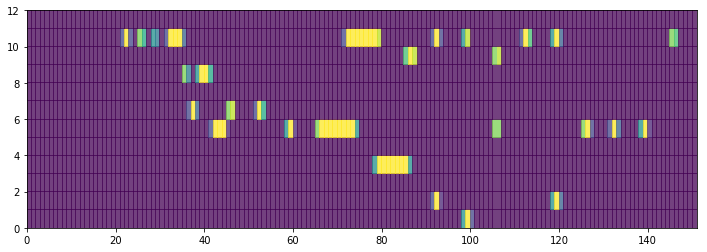

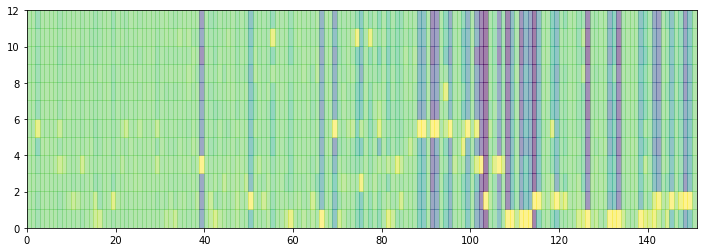

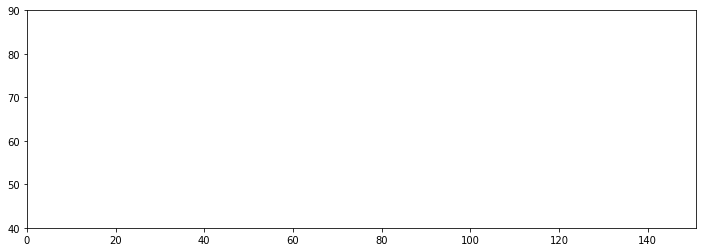

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 29s 713us/step - loss: 11.4835 - acc: 0.2402 - val_loss: 9.9676 - val_acc: 0.3174
Epoch 2/2
40000/40000 [==============================] - 19s 472us/step - loss: 9.4859 - acc: 0.3754 - val_loss: 8.9900 - val_acc: 0.4560


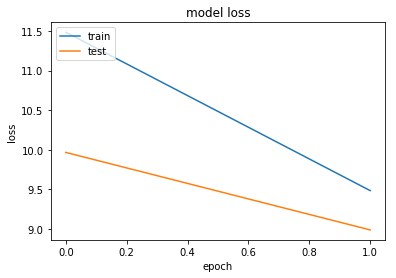

(151, 800) (151, 12)


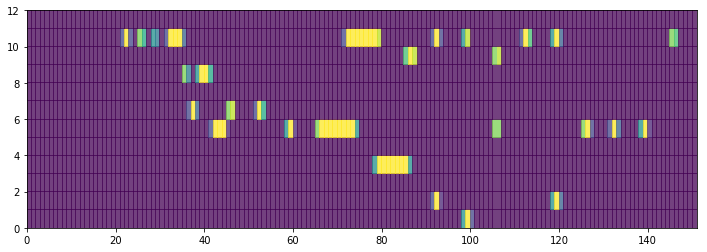

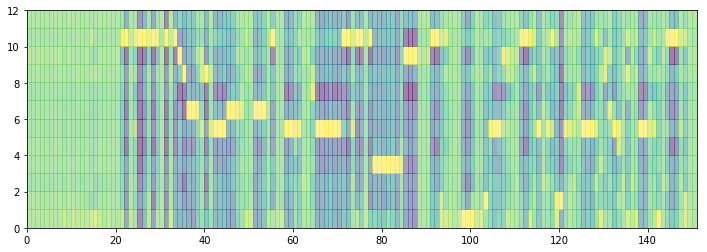

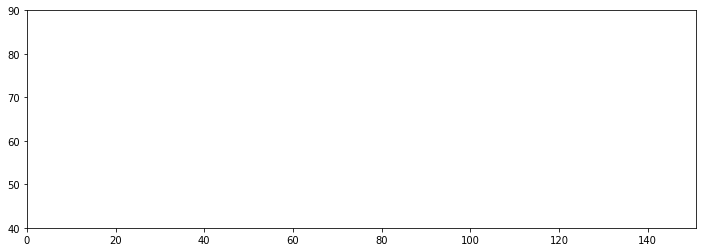

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 28s 705us/step - loss: 8.8742 - acc: 0.4344 - val_loss: 8.5279 - val_acc: 0.4536
Epoch 2/2
40000/40000 [==============================] - 19s 470us/step - loss: 8.5422 - acc: 0.4496 - val_loss: 8.3609 - val_acc: 0.4671


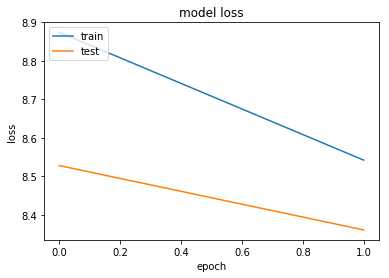

(151, 800) (151, 12)


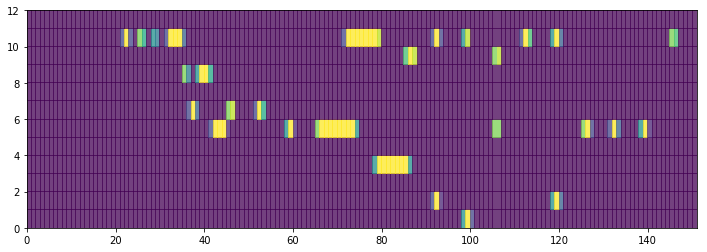

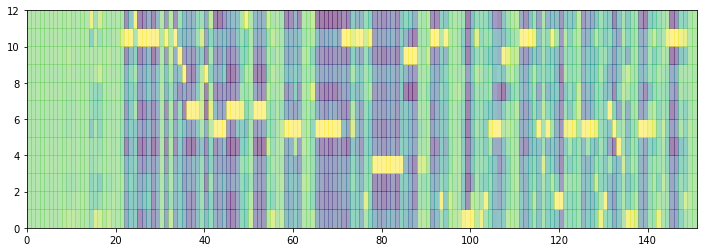

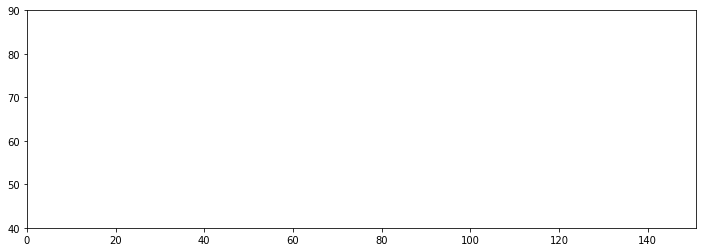

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 28s 710us/step - loss: 8.3874 - acc: 0.4545 - val_loss: 8.2132 - val_acc: 0.4324
Epoch 2/2
40000/40000 [==============================] - 19s 472us/step - loss: 8.2496 - acc: 0.4559 - val_loss: 8.1173 - val_acc: 0.4795


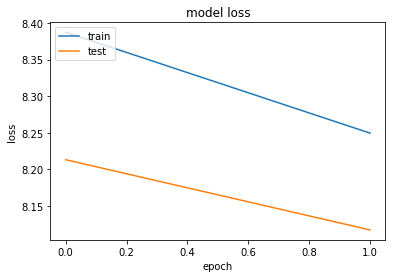

(151, 800) (151, 12)


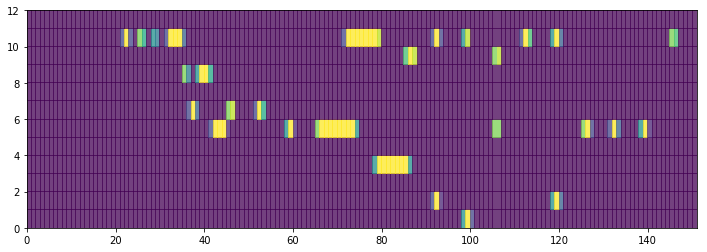

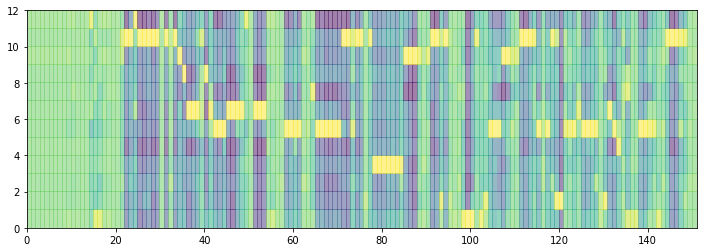

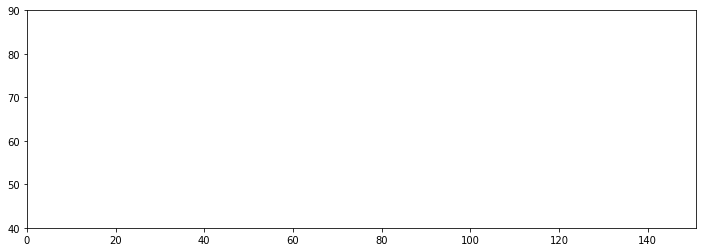

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
39904/40000 [============================>.] - ETA: 0s - loss: 8.1650 - acc: 0.4608

KeyboardInterrupt: 

In [140]:
opt_par = {'lr': 0.001, 'momentum': 0.005,'decay':0.000}
# for Xs,Ys in cDATA:
# LOSS = 'kullback_leibler_divergence'
LOSS = abs_KL_div
# LOSS = 'binary_crossentropy'
# LOSS = 'mse'
Xs,Ys = cDATA
# Xs = Xs[:N,:]
# Ys = pDs
graph  = 1
if 1:
#     compare(log = 1, mode = 'test',chroma = 0,overlap = 0, best_agent=agent)
    if graph:
        util_nn.compare(log = 1,DATA = tDATA[DIR],chroma = 0,overlap = 0, best_agent=agent,loss_func = loss_func)
#     compare(log = 1, mode = 'test',chroma = 0)
        plt.show()

    for i in range(5):
        agent,r = pretrain(agent,
#                            batchsize=-1,
                            batchsize = 50000,
#                            bsize = 1024,
                           bsize = 32,
#                             batchsize = 100000,
#                            callbacks = default_callbacks(agent),
                            callbacks = [],
                           nepc = 2)
        if graph:
            util_nn.compare(log = 1,DATA = tDATA[DIR], mode = 'test',chroma = 0,overlap = 0, best_agent=agent,loss_func = loss_func)
#     compare(log = 1, mode = 'test',chroma = 0)
        plt.show()

In [49]:
N = 30000
pYs = agent.model.predict_on_batch(Xs[:N,:])
Y = Ys[:N,:]
pDs = pYs - Y

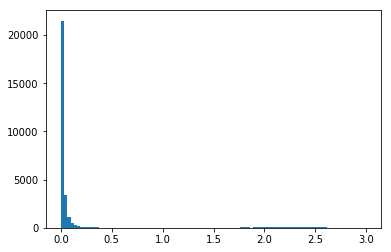

In [56]:
err = loss_func(Ys[:N,:],pYs)
err_bysample = err.mean(axis = 1)

# plt.hist(err_bysample,70);
# X = err.ravel()
# X = np.log(X+1E-5)
# X = (err**2.5).mean(axis = 1)
# X = (err**1).mean(axis = 1)
# X = pYs
# X = err.mean(axis = 1)
X = (err**0.5).mean(axis = 1)
plt.hist( X,95,log=0);
# plt.scatter(Y,pYs)
# max(err_bysample)

In [35]:
def loss_func(y_true,y_pred):
    K = np
    K.epsilon = lambda:1E-16
    y_true = K.clip(y_true, K.epsilon(), None)
    y_pred = K.clip(y_pred, K.epsilon(), None)
#    return K.sum( K.abs( (y_true- y_pred) * (K.log(y_true / y_pred))), axis=-1)
#     return K.prod( (y_true- y_pred) * (K.log(y_true / y_pred)), axis=-1)
    prod = (1 - y_true) * (K.log( 1 -  y_pred)) + (y_true) * (K.log(y_pred))
#     prod = np.power(prod,2)
#     return K.sum( K.exp(K.sum( K.log( prod +  K.epsilon() ) ,axis = 1) )
#                 ,axis = -1)
#     return K.sum(prod,)

    return prod

In [53]:
def loss_func(y_true,y_pred):
    K = np
    K.epsilon = lambda:1E-16
    y_true = K.clip(y_true, K.epsilon(), None)
    y_pred = K.clip(y_pred, K.epsilon(), None)
#    return K.sum( K.abs( (y_true- y_pred) * (K.log(y_true / y_pred))), axis=-1)
#     return K.prod( (y_true- y_pred) * (K.log(y_true / y_pred)), axis=-1)
    prod = (y_true- y_pred) * (K.log(y_true / y_pred))
#     prod = np.power(prod,2)
#     return K.sum( K.exp(K.sum( K.log( prod +  K.epsilon() ) ,axis = 1) )
#                 ,axis = -1)
#     return K.sum(prod,)

    return prod

err = loss_func(Ys[:N,:],pYs)

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   6.00000000e+00,
          7.00000000e+00,   7.00000000e+00,   6.00000000e+00,
          1.20000000e+01,   1.60000000e+01,   2.30000000e+01,
          2.40000000e+01,   2.80000000e+01,   4.00000000e+01,
          5.10000000e+01,   6.00000000e+01,   6.60000000e+01,
          5.50000000e+01,   8.10000000e+01,   6.90000000e+01,
          9.70000000e+01,   9.00000000e+01,   1.13000000e+02,
          9.40000000e+01,   8.40000000e+01,   9.70000000e+01,
          1.08000000e+02,   8.80000000e+01,   7.30000000e+01,
          5.70000000e+01,   5.70000000e+01,   6.70000000e+01,
          4.10000000e+01,   4.60000000e+01,   5.10000000e+01,
        

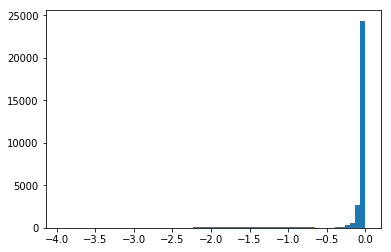

In [41]:
err_bysample = err.mean(axis = 1)
plt.hist(err_bysample,60)

In [9]:
agent.load()

In [66]:
NZidx.shape
Xs.shape

(567616, 800)

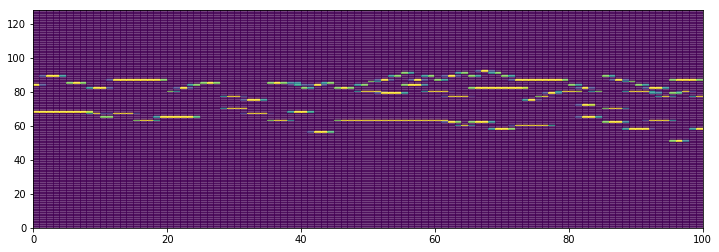

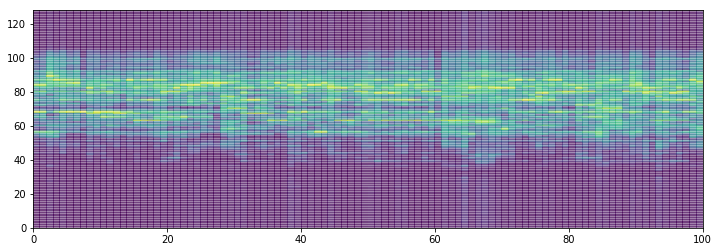

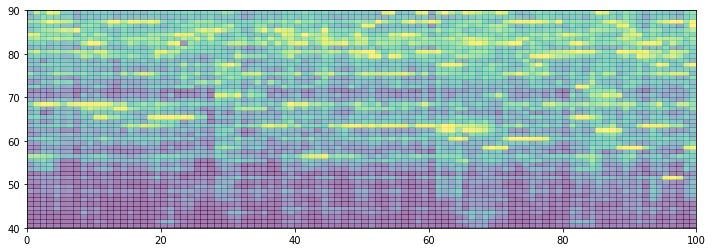

Train on 454092 samples, validate on 113524 samples

Epoch 1/2
453632/454092 [============================>.] - ETA: 0s - loss: 1.2185 - acc: 0.4311
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.43296, saving model to Models/sgd_t24_lr_0Dot001-momentum_0Dot75-decay_0Dot0-01-0.43.hdf5
454092/454092 [==============================] - 116s 256us/step - loss: 1.2185 - acc: 0.4311 - val_loss: 1.2066 - val_acc: 0.4330

Epoch 2/2
453632/454092 [============================>.] - ETA: 0s - loss: 1.1991 - acc: 0.4324
Epoch 00002: saving model to Models/tst-best_only.hdf5
Epoch 00002: val_acc did not improve
454092/454092 [==============================] - 105s 232us/step - loss: 1.1991 - acc: 0.4324 - val_loss: 1.1974 - val_acc: 0.4313


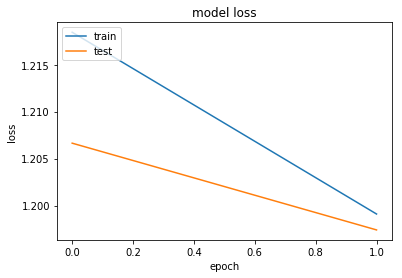

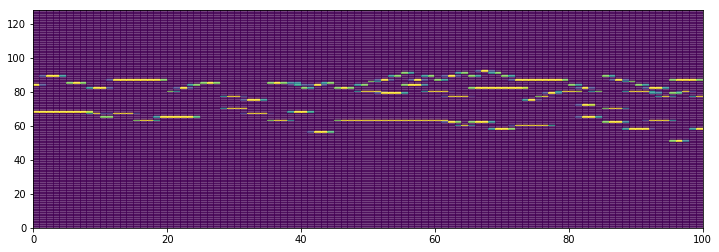

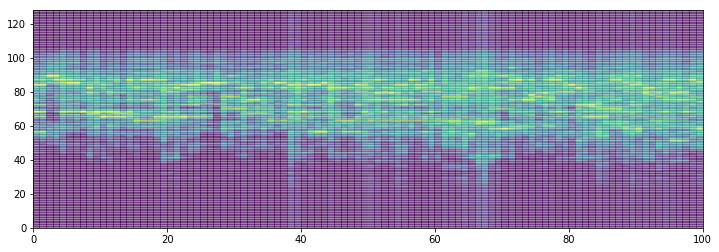

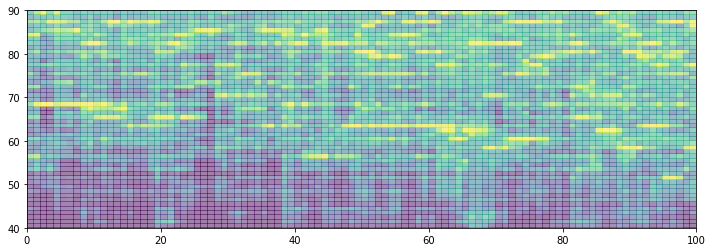

Train on 454092 samples, validate on 113524 samples

Epoch 1/2
376832/454092 [=======================>......] - ETA: 17s - loss: 1.1923 - acc: 0.4319

KeyboardInterrupt: 

In [67]:
opt_par = {'lr': 0.001, 'momentum': 0.75,'decay':0.000}
# for Xs,Ys in cDATA:
Xs,Ys = cDATA
# Ys = Ys > 0
# SUM = Ys.sum(axis = 1,keepdims=1)
# SUM[SUM==0]=1
# Ys = Ys/SUM
if 1:
    compare(log = 1, mode = 'test',chroma = 0,overlap = 0, best_agent=agent)
#     compare(log = 1, mode = 'test',chroma = 0)
    plt.show()

    for i in range(5):
        agent,r = pretrain(agent,
                           batchsize=-1,
#                             batchsize = 50000,
#                             batchsize = 100000,
                           nepc = 2)
        compare(log = 1, mode = 'test',chroma = 0,overlap = 0, best_agent=agent)
#     compare(log = 1, mode = 'test',chroma = 0)
        plt.show()

sample/MIDI/jsbach/jsbwv533P-2S60


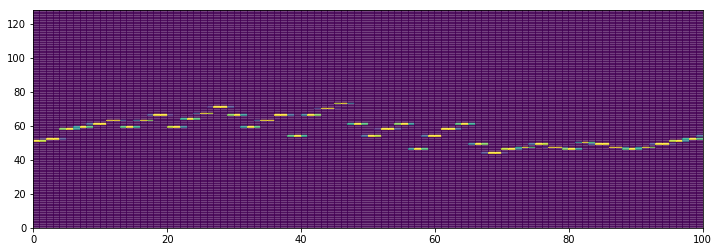

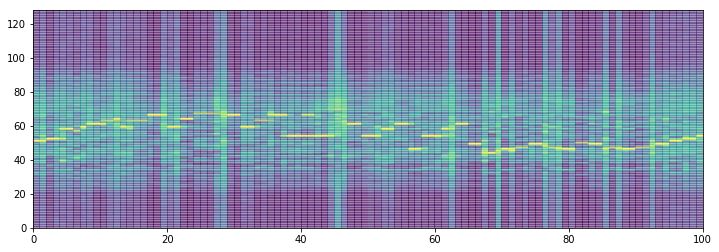

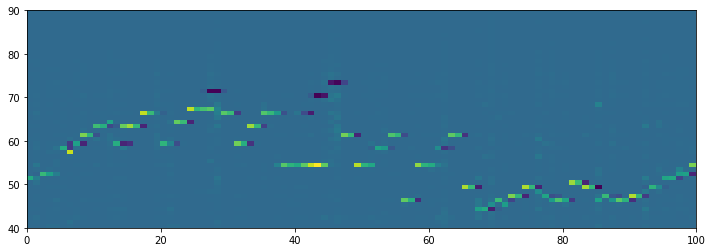

In [7]:
print data[0]['name']
compare(log = 1, mode = 'test',chroma = 0,overlap = 0, best_agent=agent)

In [ ]:
agent = _

In [64]:
def to_chunk(self,new_rate):
    ratio = self.bitrate/new_rate
    idx = np.arange(0, len(self.ts) ,ratio).astype(int)
    print len(idx)
    return np.array(np.split(self.xs, idx[1:])[:-1])

def transcribe(signal, agent,norm = 1, chroma = 1, log = 1):
    if isinstance( signal, util.piece):
        signal.downsample(16000)
        signal = signal.to_chunk(20)
#     plt.figure()

#     assert not (pXs[0] - Xs[0]).any()
#     pXs = Xs[:500]
#     pYs_exp = Ys[:500]
    pYs_act = agent.model.predict_on_batch(signal) 
#     pYs_act = pYs_act * np.arange(pYs_act.shape[1])[None,:]
    pYs_act += 1E-10
#     compare(log = 1)
    if chroma:
#        pYs_exp = mroll2chroma(pYs_exp)
        pYs_act = mroll2chroma(pYs_act,norm = 1)        
    Z1 = pYs_act.T
    if log:
        plt.pcolormesh(Z1,
                       alpha = 1.0,
                  norm=matplotlib.colors.LogNorm(vmin=Z1.min(), vmax=Z1.max())
                  )
    else:
        plt.pcolormesh(Z1)
    fs = np.arange(pYs_act.shape[-1])[None,:]
    pYs_act = (pYs_act)*fs
    ipd.display(ipd.Audio(midi_roll_play(pYs_act),rate = 16000))
    return pYs_act
import librosa
import librosa.display
def cqt(p):
    sr = p.bitrate
    y  = p.xs
    chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr, 
#                                            window = 50,
#                                           hop_length = 1
                                          )
    librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
    plt.show()
    return chroma_cq.T
def stft(p):
    sr = p.bitrate
    y  = p.xs
    chroma_cq = librosa.feature.chroma_stft(y=y, sr=sr,
                                           n_chroma=12, n_fft=800,
                                           hop_length=800)
    librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
    plt.show()
    return chroma_cq.T
# cqt(p)
# stft(p)
# compare(log = 0)

import util#

best_agent = agent
def evaluate(best_agent,log= 1):
#     wavfile = 'sample/waltz_for_toutzy.wav'
    wavfile = 'sample/waltz_for_toutzy_50.wav'
#     wavfile = 'sample/Tamacun.wav'
#     wavfile = 'sample/MIDI/composer-bach-edition-bg-genre-cant-work-0002-format-midi1-multi-zip-number-01.wav'
    p = util.piece(wavfile)
    print p.x0.max()
    if p.x0.dtype=='int16':
        p.x0 = p.x0.astype('float32')
        p.x0 = p.x0/2**15
    p.xs = p.x0
    # p.xs = p.xs.astype('float32')
    p.downsample(16000)
    # p.bitrate = 18000
#     p.trimto(18,26)
    p.trimto(28,40)
    # p.trimto(18,66)
    # p.trimto(60,100)
    # p.trimto(100,140)
    # print len(p.xs)
    chunks = to_chunk(p,20)[:]
    chunks = np.array(chunks)
    # chunks = util_midi.norm_by_rmsq(chunks,norm = 1)

    eps = 1E-8
    # chunks_SD = chunks.std(axis = 1,keepdims= 1) + eps
    # chunks_M = chunks.mean(axis = 1,keepdims= 1) 
    # # NZidx = np.squeeze( (chunks_SD)/chunks_M > 8)
    # # chunks = chunks[NZidx,:]; mroll=mroll[NZidx,:]            
    # # chunks = (chunks - chunks_M[NZidx,:])/chunks_SD[NZidx,:]
    # chunks = (chunks - chunks_M)/chunks_SD
    # chunks.shape
    # len(p.x0)
    # print len(chunks)
    plt.figure(figsize = [12,6])
    mroll = transcribe(chunks,best_agent,chroma = 0,log = log)
    
    ytk = librosa.midi_to_note(range(0,128))
    plt.yticks(np.arange(0,128) +.5,librosa.midi_to_note(range(0,128)))
    plt.ylim(40,78)
    plt.grid()
#     plt.ylim(30,90)

    ipd.display(ipd.Audio(p.xs,rate=16000))
    plt.figure(figsize = [12,6])
    # print p.xs.dtype
    cqt(p)


In [ ]:
# 'C','C#'
import librosa


In [36]:
evaluate(PGAgent(800,128,model= old_model),log = 1)

NameError: name 'old_model' is not defined

0.965485
240


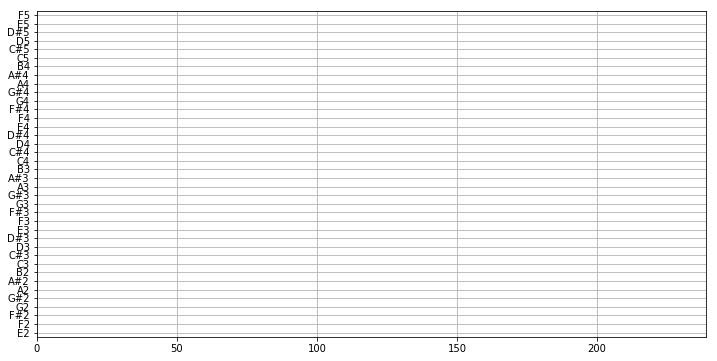

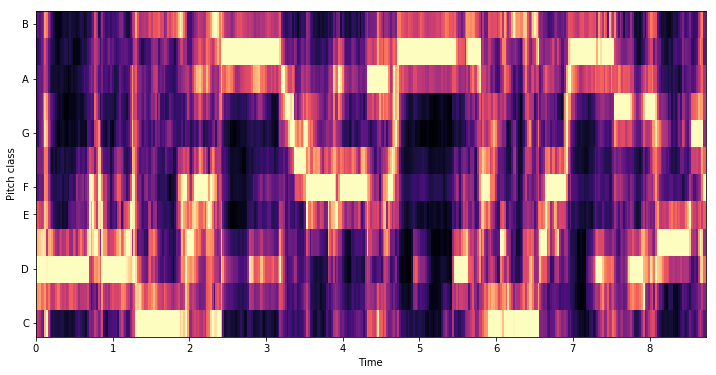

In [103]:
evaluate(agent,log = 1)

0.965485
240


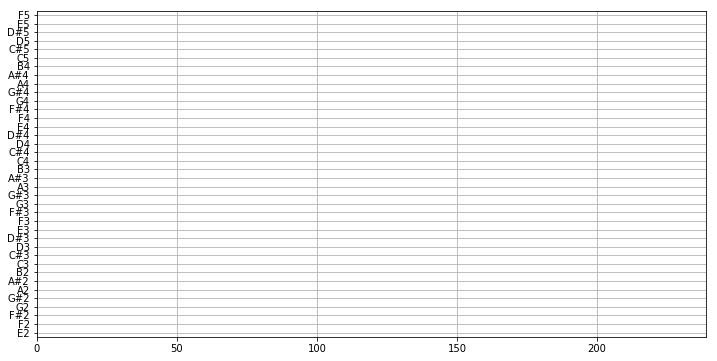

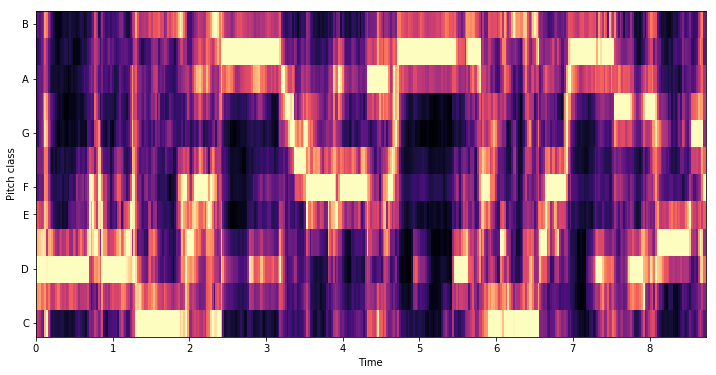

In [65]:
evaluate(agent)

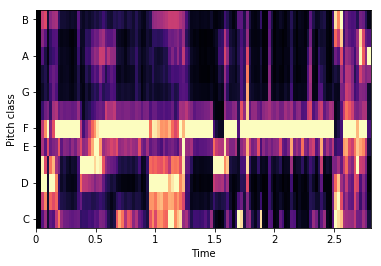

In [59]:
ipd.Audio(midi_roll_play(stft(p)),rate=16000)

In [149]:
%%bash
cd sample
wget "https://www.audioblocks.com/join/register?pre_email_click=details"
# !pip install librosa --user 


--2017-12-09 20:48:43--  https://www.audioblocks.com/join/register?pre_email_click=details
Resolving www.audioblocks.com (www.audioblocks.com)... 52.203.100.91, 52.203.214.179
Connecting to www.audioblocks.com (www.audioblocks.com)|52.203.100.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘register?pre_email_click=details.1’

     0K .......... .......... .......... .......... ..........  260K
    50K ....                                                    160M=0.2s

2017-12-09 20:48:44 (282 KB/s) - ‘register?pre_email_click=details.1’ saved [55613]



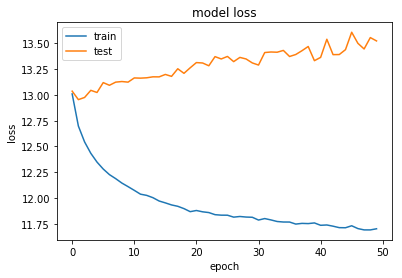

In [80]:
plot_model_loss(r)
# %matplotlib inline
# plt.plot(r.history['val_acc'])